In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn



## Loading Dataset

In [64]:
train_data = pd.read_csv("/kaggle/input/google-stock-2010-2023/Google_Stock_Train (2010-2022).csv")
test_data = pd.read_csv("/kaggle/input/google-stock-2010-2023/Google_Stock_Test (2023).csv")
test_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,89.589996,91.050003,88.519997,89.120003,89.120003,28131200
1,2023-01-04,90.349998,90.650002,87.269997,88.080002,88.080002,34854800
2,2023-01-05,87.470001,87.570000,85.900002,86.199997,86.199997,27194400
3,2023-01-06,86.790001,87.690002,84.860001,87.339996,87.339996,41381500
4,2023-01-09,88.360001,90.050003,87.860001,88.019997,88.019997,29003900
...,...,...,...,...,...,...,...
138,2023-07-24,121.660004,123.000000,120.980003,121.529999,121.529999,29686100
139,2023-07-25,121.360001,123.150002,121.019997,122.209999,122.209999,52509600
140,2023-07-26,130.070007,130.979996,128.320007,129.270004,129.270004,61682100
141,2023-07-27,131.669998,133.240005,128.789993,129.399994,129.399994,44952100


In [25]:
train_data = train_data[['Date', 'Close']]
test_data = test_data[['Date', 'Close']]
train_data

,Date,Close
0,2010-01-04,15.684434
1,2010-01-05,15.615365
2,2010-01-06,15.221722
3,2010-01-07,14.867367
4,2010-01-08,15.065566
...,...,...
3267,2022-12-23,89.230003
3268,2022-12-27,87.389999
3269,2022-12-28,86.019997
3270,2022-12-29,88.449997


In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

/tmp/ipykernel_32/792462508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Date'] = pd.to_datetime(test_data['Date'])


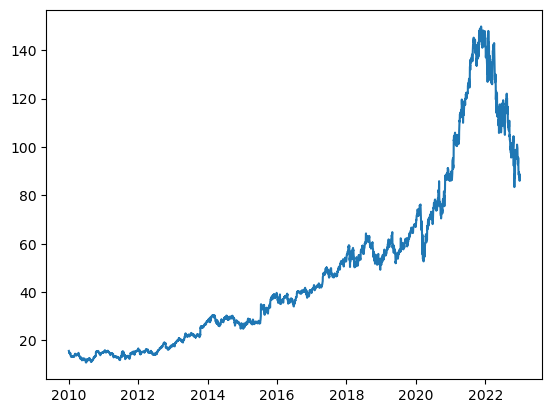

In [27]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
plt.plot(train_data['Date'], train_data['Close'])

## Formatting Data for LSTM

In [28]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(train_data, lookback)
test_df = prepare_dataframe_for_lstm(test_data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2010-01-13,14.691942,14.776777,15.042793,15.065566,14.867367,15.221722,15.615365,15.684434
2010-01-14,14.761011,14.691942,14.776777,15.042793,15.065566,14.867367,15.221722,15.615365
2010-01-15,14.514515,14.761011,14.691942,14.776777,15.042793,15.065566,14.867367,15.221722
2010-01-19,14.705205,14.514515,14.761011,14.691942,14.776777,15.042793,15.065566,14.867367
2010-01-20,14.524775,14.705205,14.514515,14.761011,14.691942,14.776777,15.042793,15.065566
...,...,...,...,...,...,...,...,...
2022-12-23,89.230003,87.760002,89.580002,89.019997,88.440002,90.260002,90.860001,95.070000
2022-12-27,87.389999,89.230003,87.760002,89.580002,89.019997,88.440002,90.260002,90.860001
2022-12-28,86.019997,87.389999,89.230003,87.760002,89.580002,89.019997,88.440002,90.260002


In [29]:
shifted_df_as_np = shifted_df.to_numpy()
test_df_as_np = test_df.to_numpy()
shifted_df_as_np

array([[14.691942, 14.776777, 15.042793, ..., 15.221722, 15.615365,
        15.684434],
       [14.761011, 14.691942, 14.776777, ..., 14.867367, 15.221722,
        15.615365],
       [14.514515, 14.761011, 14.691942, ..., 15.065566, 14.867367,
        15.221722],
       ...,
       [86.019997, 87.389999, 89.230003, ..., 89.019997, 88.440002,
        90.260002],
       [88.449997, 86.019997, 87.389999, ..., 89.580002, 89.019997,
        88.440002],
       [88.230003, 88.449997, 86.019997, ..., 87.760002, 89.580002,
        89.019997]])

In [30]:
shifted_df_as_np.shape

(3265, 8)

## Scaling the Data with MinMaxScaler

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
test_df_as_np = scaler.fit_transform(test_df_as_np)
shifted_df_as_np

array([[-0.94559286, -0.94437156, -0.94054195, ..., -0.93796605,
        -0.9322991 , -0.93130477],
       [-0.94459853, -0.94559286, -0.94437156, ..., -0.94306741,
        -0.93796605, -0.9322991 ],
       [-0.94814713, -0.94459853, -0.94559286, ..., -0.9402141 ,
        -0.94306741, -0.93796605],
       ...,
       [ 0.08125796,  0.10098074,  0.12746975, ...,  0.12444647,
         0.11609676,  0.14229779],
       [ 0.11624065,  0.08125796,  0.10098074, ...,  0.1325084 ,
         0.12444647,  0.11609676],
       [ 0.11307358,  0.11624065,  0.08125796, ...,  0.10630737,
         0.1325084 ,  0.12444647]])

In [33]:
X_train = shifted_df_as_np[:, 1:]
y_train = shifted_df_as_np[:, 0]

X_test = test_df_as_np[:,1:]
y_test = test_df_as_np[:, 0]

X_train.shape, y_train.shape

((3265, 7), (3265,))

In [34]:
X_train = dc(np.flip(X_train, axis=1))
X_test = dc(np.flip(X_test, axis=1))


In [35]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

## Turning the Data into Tensor

In [36]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3265, 7, 1]),
 torch.Size([136, 7, 1]),
 torch.Size([3265, 1]),
 torch.Size([136, 1]))

## Creating Dataset using PyTorch Dataset Class

In [37]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [38]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Creating Model

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 5, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

## Train Loop

In [40]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

## Validation Loop

In [41]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, (X,y) in enumerate(test_loader):
        x_batch, y_batch = X.to(device), y.to(device)
        
        with torch.inference_mode():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

## Setting Up LR, LF, and Optimizer

In [44]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.002

Val Loss: 0.037
***************************************************

Epoch: 2
Batch 100, Loss: 0.001

Val Loss: 0.040
***************************************************

Epoch: 3
Batch 100, Loss: 0.001

Val Loss: 0.036
***************************************************

Epoch: 4
Batch 100, Loss: 0.001

Val Loss: 0.037
***************************************************

Epoch: 5
Batch 100, Loss: 0.001

Val Loss: 0.036
***************************************************

Epoch: 6
Batch 100, Loss: 0.001

Val Loss: 0.035
***************************************************

Epoch: 7
Batch 100, Loss: 0.001

Val Loss: 0.037
***************************************************

Epoch: 8
Batch 100, Loss: 0.001

Val Loss: 0.030
***************************************************

Epoch: 9
Batch 100, Loss: 0.001

Val Loss: 0.037
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.034
********************************

In [54]:
import math
from sklearn.metrics import mean_squared_error

## Visualizing the Predictions and MSE

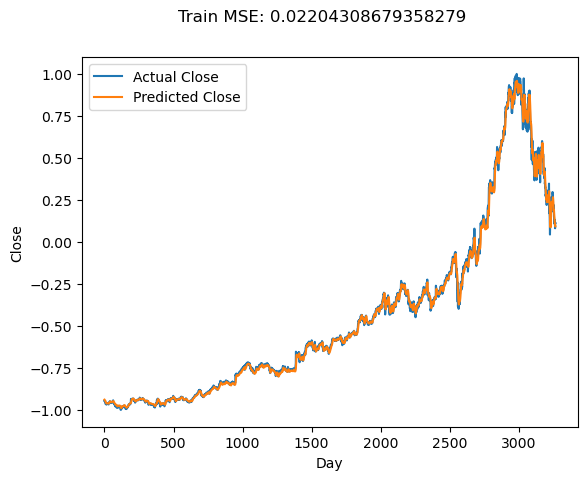

In [60]:
with torch.inference_mode():
    predicted = model(X_train.to(device)).to('cpu').numpy()

error = math.sqrt(mean_squared_error(y_train,predicted))
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.suptitle(f'Train MSE: {error}')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


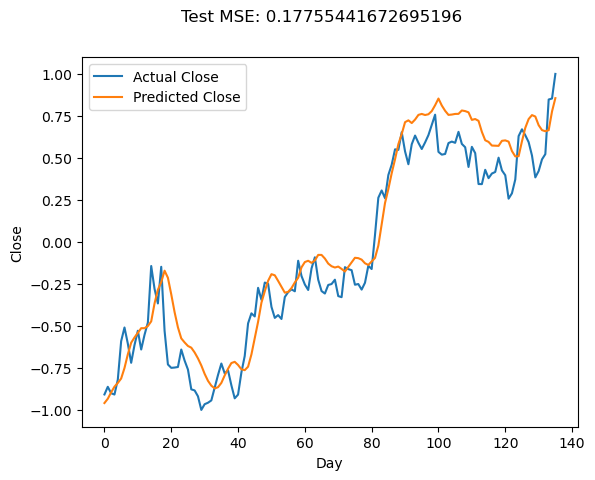

In [62]:
with torch.inference_mode():
    predicted = model(X_test.to(device)).to('cpu').numpy()

error = math.sqrt(mean_squared_error(y_test,predicted))
plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.suptitle(f'Test MSE: {error}')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
